In [15]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import cv2

In [103]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, Add
from tensorflow.keras.layers import LeakyReLU, ReLU

In [10]:
MODEL_DIR = "../assets/model/"
DATA_DIR = "../assets/data/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.txt")
IMAGES_DIR = os.path.join(DATA_DIR, "samples")

(455, 320, 3)


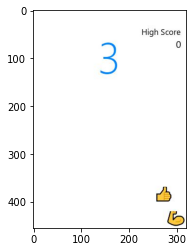

In [73]:
im = cv2.imread(os.path.join(IMAGES_DIR, "sample_0.JPEG"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

SRC_HEIGHT, SRC_WIDTH, SRC_DEPTH = im.shape

In [100]:
image_gen = ImageDataGenerator(validation_split=0.3, rescale=1.0/255.0)
dataframe = pd.read_csv(LABELS_FILE, delim_whitespace=True)

TARGET_SIZE = (SRC_HEIGHT//2, SRC_WIDTH//2)
OUTPUT_SHAPE = 3

BATCH_SIZE = 100

#TARGET_COLUMNS = ["x_centre", "y_centre", "width", "height", "confidence"]
TARGET_COLUMNS = ["x_centre", "y_centre", "confidence"]

training_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col=TARGET_COLUMNS,
    subset="training",
    batch_size=BATCH_SIZE,
    class_mode="raw",
    target_size=TARGET_SIZE)

validation_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col=TARGET_COLUMNS,
    subset="validation",
    batch_size=BATCH_SIZE,
    class_mode="raw",
    target_size=TARGET_SIZE)

Found 7000 validated image filenames.
Found 3000 validated image filenames.


In [101]:
batch = training_generator.next()

[0.6546875  0.36813187 1.        ]


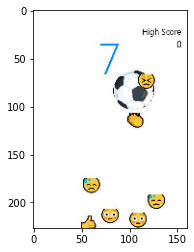

In [102]:
i = 12
X, y = batch[0][i], batch[1][i]
print(y)
plt.imshow(X)

In [117]:
def create_model():
    alpha = 0.2
    dropout = 0.1

    inputs = Input(shape=TARGET_SIZE+(3,))

    x_skip = inputs
    
    x = Conv2D(16, (3, 3))(inputs)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x_skip = Conv2D(64, (16, 16))(x_skip)
    x_skip = MaxPooling2D((17,17))(x_skip)
    x = Add()([x, x_skip])

    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    x = Dense(128)(x)
    x = ReLU()(x)
    
    x = Dense(64)(x)
    x = ReLU()(x)

    x = Dense(32)(x)
    x = ReLU()(x)

    x = Dense(OUTPUT_SHAPE)(x)
    outputs = x
    #outputs = LeakyReLU(alpha)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss="mse",
    metrics=["accuracy"],
)

print(model.summary())

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 227, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 225, 158, 16) 448         input_31[0][0]                   
__________________________________________________________________________________________________
re_lu_67 (ReLU)                 (None, 225, 158, 16) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_104 (MaxPooling2D (None, 112, 79, 16)  0           re_lu_67[0][0]                   
______________________________________________________________________________________

In [81]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

print("steps per epoch: {0}".format(steps_per_epoch))
print("validation steps {0}".format(validation_steps))

TOTAL_EPOCHS = 10

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=TOTAL_EPOCHS,
)

steps per epoch: 70
validation steps 30
Epoch 1/10
22/70 [========>.....................] - ETA: 1:43 - loss: 0.1912 - accuracy: 0.4836

KeyboardInterrupt: 

In [ ]:
model.save_weights("../models/cnn_64_64.h5f")